# Attendance Sheet Scanner Digital Image Processing Project Fall - 2022


# Loading the Dataset From The Google Drive

In [1]:
# from google.colab import files
# uploaded =files.upload()

In [2]:
# ! pip install imutils
import pprint
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform # For AFFINE TRANSFORMATION
import os
from skimage.feature import hog

In [3]:
# General Function for Displaying the Image
def imshow_single_image(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def imshow_two_images(image1, title1, image2,title2,gray_flag):
    if gray_flag==1:
        plt.figure(figsize=[20,10])
        plt.subplot(121); plt.axis('off'); plt.imshow(image1,cmap='gray'); plt.title(title1)
        plt.subplot(122); plt.axis('off'); plt.imshow(image2,cmap='gray'); plt.title(title2)

    else:
        plt.figure(figsize=[20,10])
        plt.subplot(121); plt.axis('off'); plt.imshow(image1); plt.title(title1)
        plt.subplot(122); plt.axis('off'); plt.imshow(image2); plt.title(title2)

In [4]:
# Displaying the Image
path_custom_sheet ='input/custom/'
path_university_sheet = 'input/university'
path_output ='output/'
cropped_dir_path ='Rows_Extracted/'

WIDTH, HEIGHT = 1920, 1080
count = 0
scale = 0.5


In [5]:
# Enter the filename you want to read
# attendance_sheet = cv2.imread(f'{path_university_sheet}/1.jpg')
attendance_sheet = cv2.imread(f'abc.jpg')

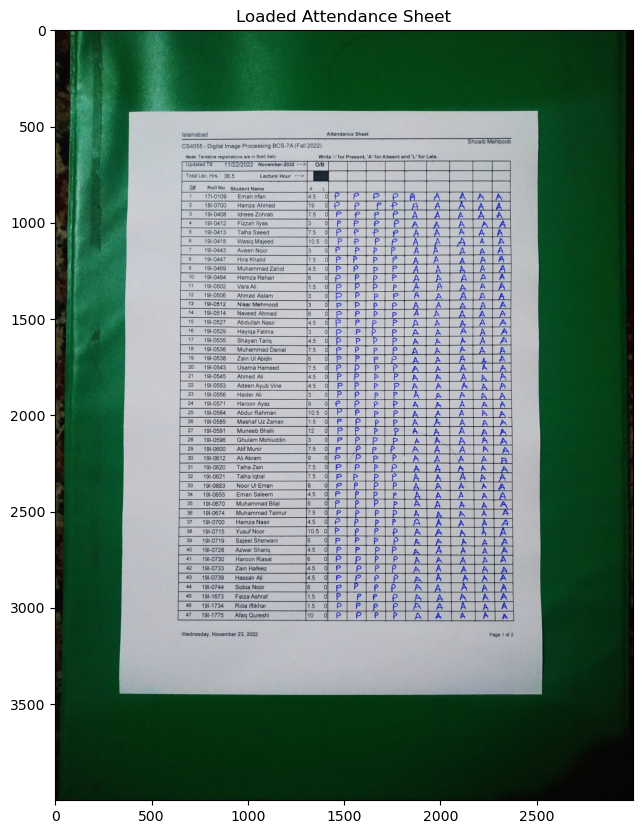

In [6]:
# Display The Attendance Sheet
imshow_single_image(title='Loaded Attendance Sheet',image=attendance_sheet)

# Step #1 Remove The Background and Align the Foreground

In [9]:
def perform_image_registration(original_image,contour_grid):

    warped = four_point_transform(original_image, contour_grid.reshape(4, 2))
    warped =cv2.resize(warped, (int(scale * warped.shape[1]), int(scale * warped.shape[0])))
    imshow_two_images(original_image,'Original Attendance Sheet',warped,'After Transformation',1)

    return warped


def align_image(image_sheet,grayscale_flag =0):
    image_sheet_copy =image_sheet.copy()
    global contour_grid

    contour_grid = np.array([[0, 0], [WIDTH, 0], [WIDTH, HEIGHT], [0, HEIGHT]])

    if grayscale_flag ==0:
    # Step #1 Convert the image in to the grayscale image
        gray_scale_image = cv2.cvtColor(image_sheet, cv2.COLOR_BGR2GRAY)
#         imshow_two_images(image_sheet,'Original Attendance Sheet',gray_scale_image,'Gray Scale Version of the Image',1)
    elif grayscale_flag ==1:
        gray_scale_image =image_sheet


    # Step #2 Apply the gussian blur filter to remove noise
    output_of_gussian_blur =cv2.GaussianBlur(gray_scale_image, (5, 5), 1)
#     imshow_two_images(gray_scale_image,'Grayscale Attendance Sheet',output_of_gussian_blur,'Gussian Blur Version of the Image',1)

    # # Step # 3 Apply OTSU Thresholding
    # _, th2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    # Step #3 Apply the canny edge detection to find edges for contours Reson to binarize the image first
    # 200 200 best for any light condition general rule
    output_canny_edge= cv2.Canny(output_of_gussian_blur, 200, 200)
#     imshow_two_images(image_sheet,'Orignal Attendance Sheet',output_canny_edge,'Canny Edge Detection Version of the Image',1)

    # Finding Contours
    # contours, _ = cv2.findContours(output_canny_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(output_canny_edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Plotting the contours
    contoursFrame = image_sheet.copy()
    contoursFrame = cv2.drawContours(contoursFrame, contours, -1, (255, 0, 255), 4)
    imshow_two_images(output_canny_edge,'Edges of Attendance Sheet',contoursFrame,'All Contours of Attendance Sheet Located',1)


    # sorting the contours in the descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)        

    # finding the max area
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                print('a')
                document_contour = approx
                max_area = area


    # Drawing the contours now
    contour_processing_framesFrame = cv2.drawContours(image_sheet_copy, [document_contour], -1, (0, 255, 0), 3)
    imshow_two_images(contoursFrame,'All Contours',contour_processing_framesFrame,'Largest Contour Area Founded',1)

    return perform_image_registration(original_image=image_sheet,contour_grid=document_contour)


a


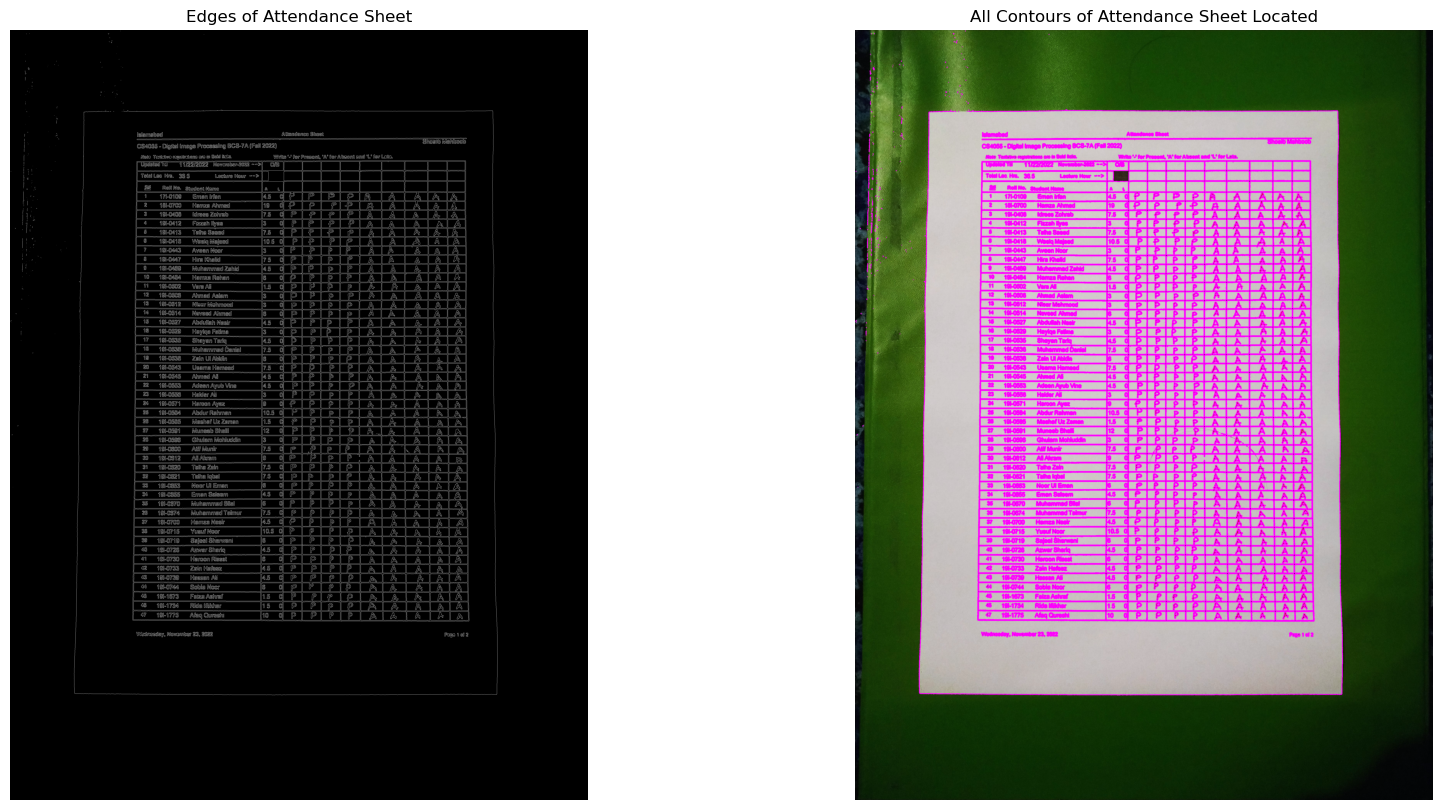

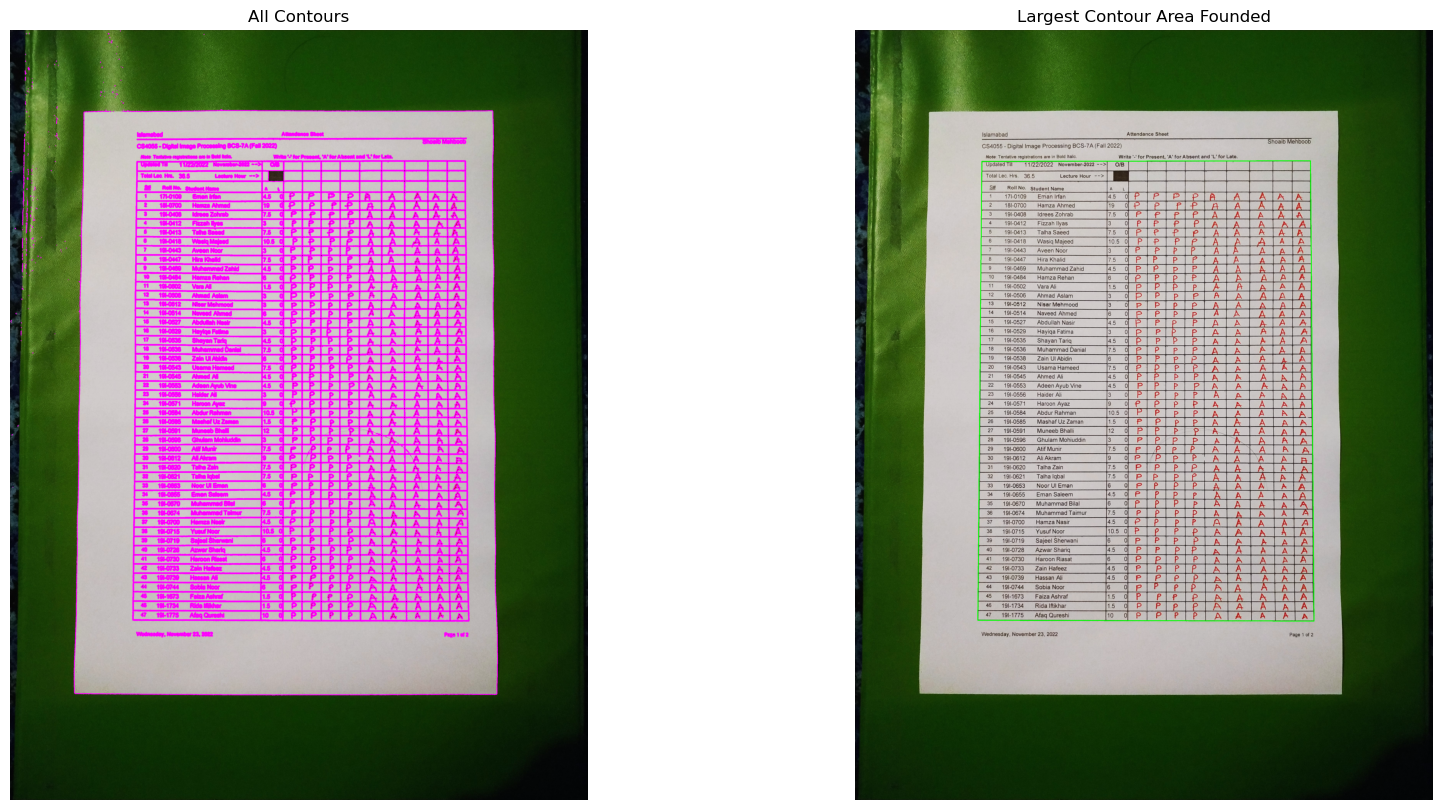

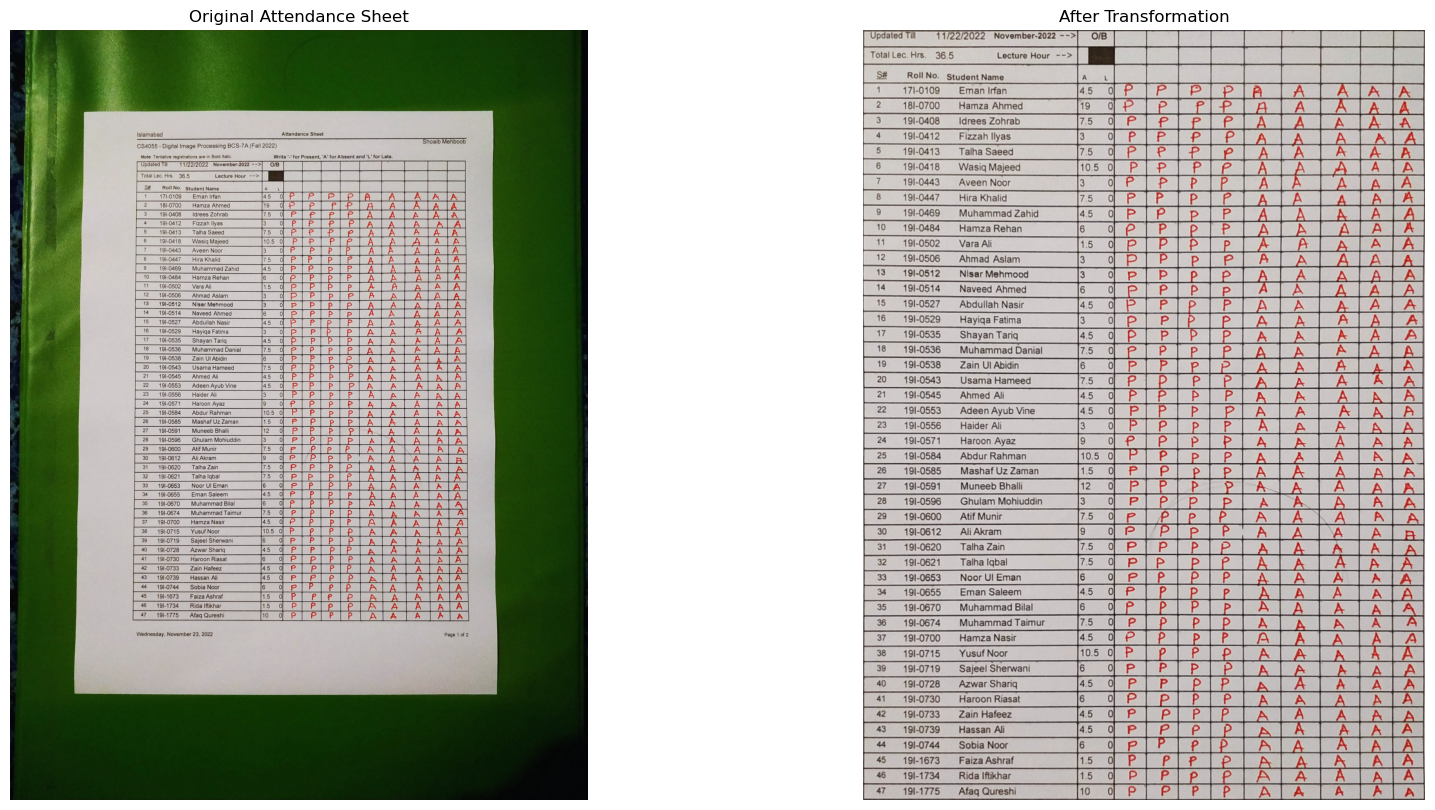

In [10]:
processed_image =align_image(attendance_sheet)
testing =processed_image.copy()

# Extracting the Table Region of Attendance Sheet


In [11]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [12]:
finalImgBin = 0
def extract_roi(processed_image):
    copy_img =processed_image.copy()

    # converting the image in to grayscale
    gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)

    # thresholding the image
    (thresh, img_bin) = cv2.threshold(gray, 128, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # invert the binary image
    img_bin = 255-img_bin 

    #display image
#     imshow_two_images(processed_image,'Original Image',img_bin,'Inverted Thursholded Image',1)  

    #--------------------------------------- Defining the Kernel -------------------------------------------------------
    # Defining a kernel length
    kernel_length = np.array(copy_img).shape[1]//80

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    #------------------- Process of detecting the vertical and horizontal lines ----------------------------------------
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)


    # displaying the vertical and horizontal lines
#     imshow_two_images(horizontal_lines_img,'Horizontal Lines',verticle_lines_img,'Vertical Lines',1)  

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#     imshow_two_images(processed_image,'Original Image',img_final_bin,'Extraced Grid of the Image',1) 
    # ----------------------------------------------------------------------------------------------------------------------

    # -----------------------Finding the largest possible contour of the thursholded image ---------------------------------
    largest_contour_binary_image =align_image(img_final_bin,1)
    imshow_two_images(img_final_bin,'Original Binary Image Thursholed',largest_contour_binary_image,'Largest Binary Contour',1) 
    finalImgBin = img_final_bin

    # Finding Contours
    # contours, _ = cv2.findContours(output_canny_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(img_final_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

    # Plotting the contours
    contoursFrame = processed_image.copy()
    contoursFrame = cv2.drawContours(contoursFrame, contours, -1, (255, 0, 255), 4)
    imshow_two_images(img_final_bin,'Binary Images',contoursFrame,'All Contours of Attendance Sheet Located',1)


    # image cutting
    idx = 0
    for c in contours:
    # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 50 and h > 20) and w > 3*h:
            idx += 1
            new_img = processed_image[y:y+h, x:x+w]
            cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)
            # imshow_single_image('single cut',new_img)



a


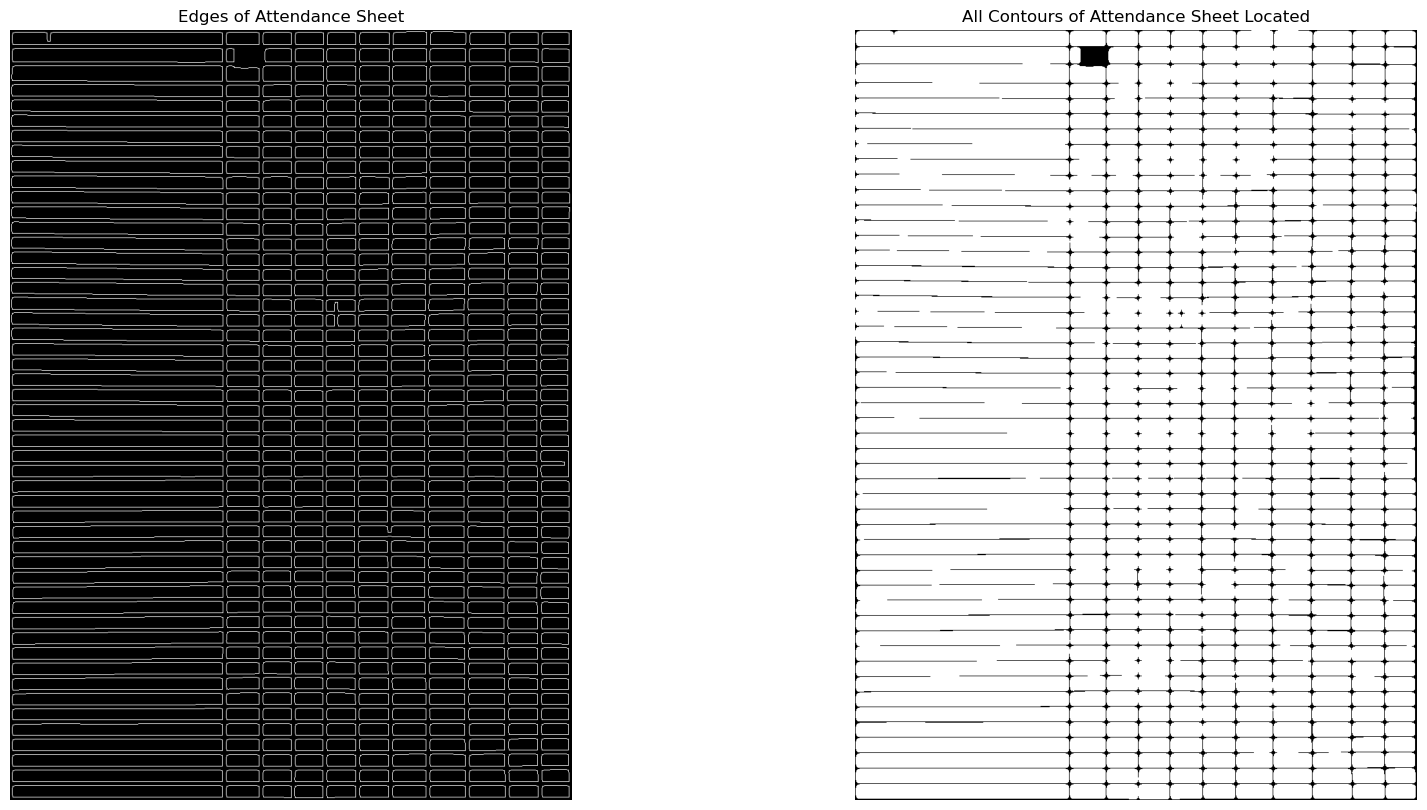

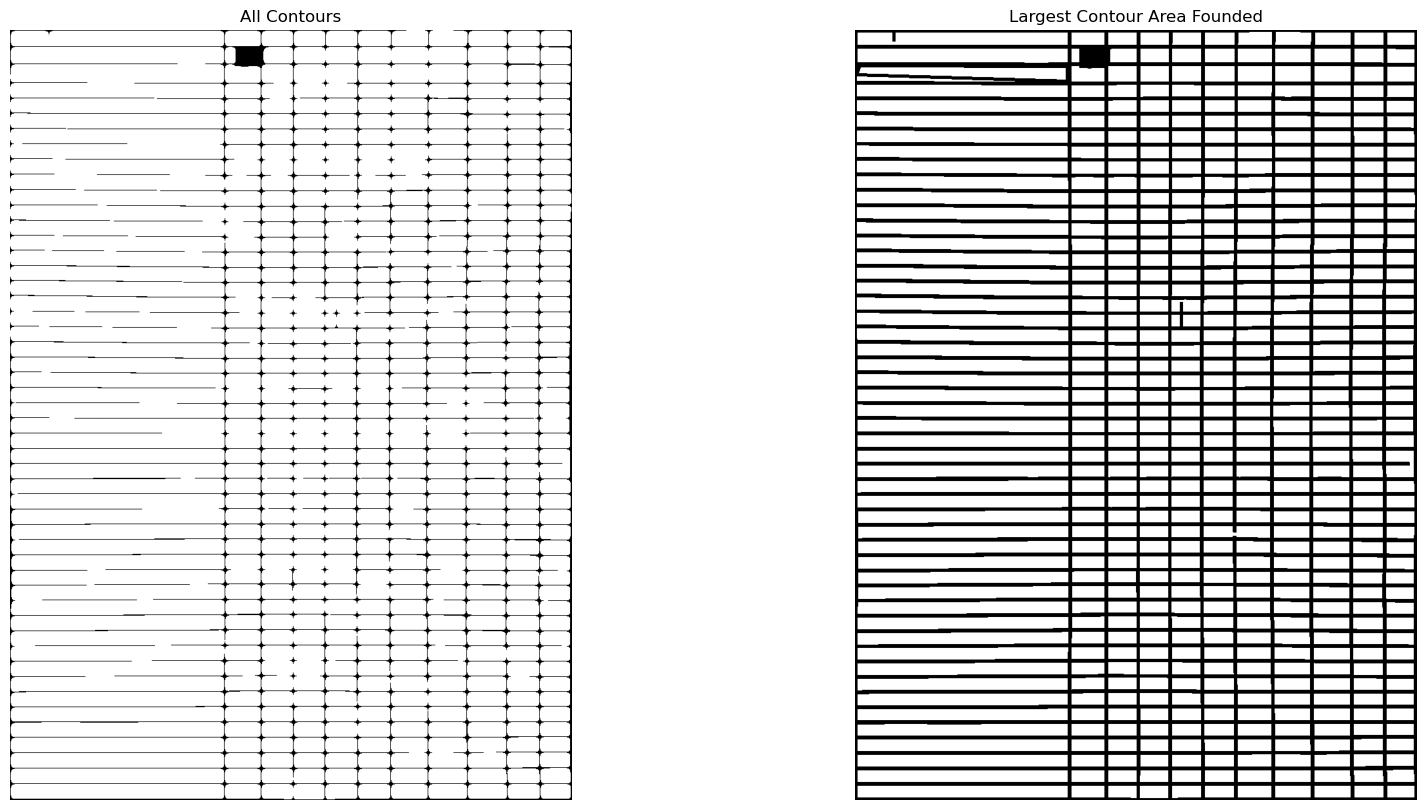

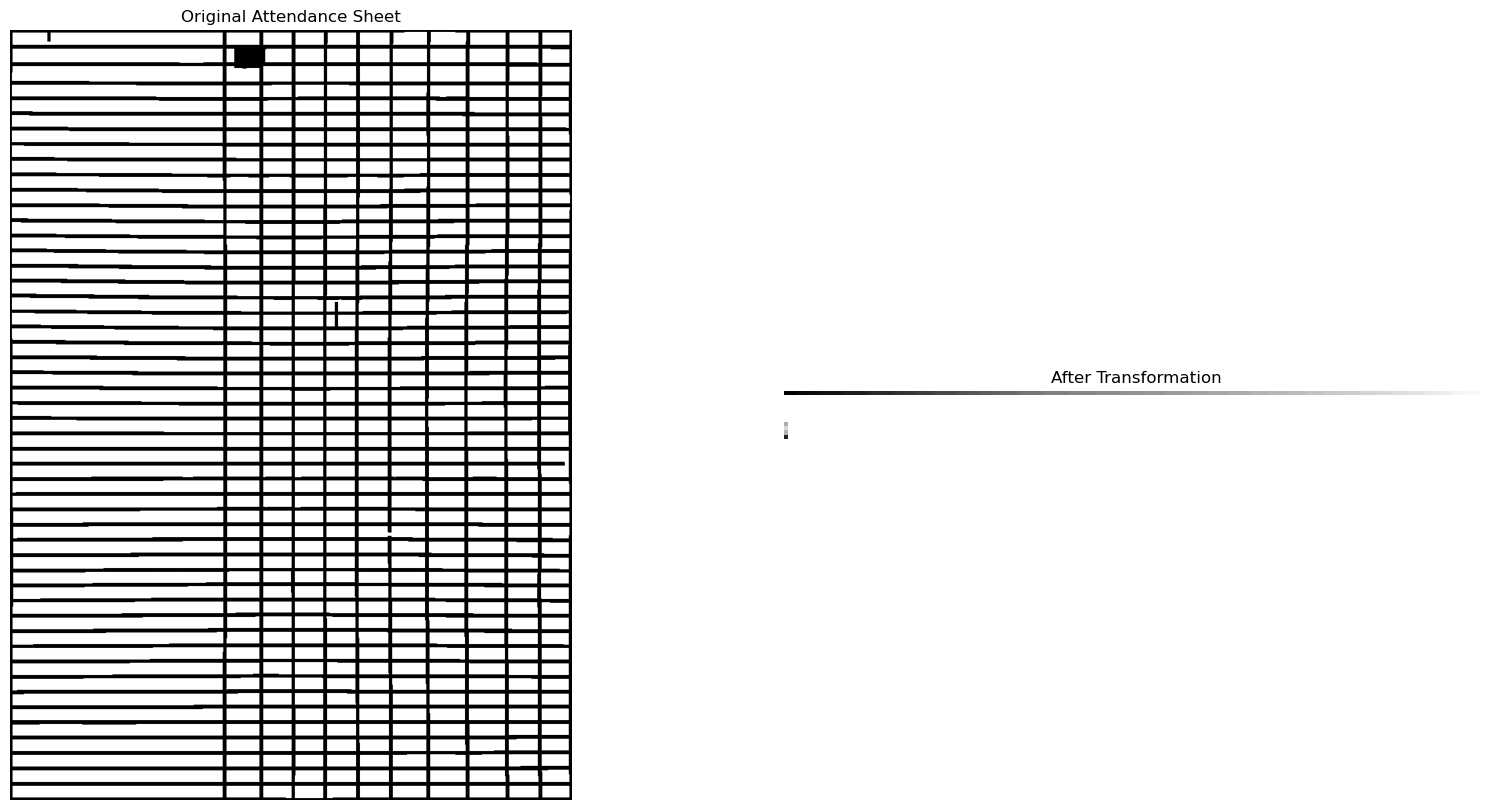

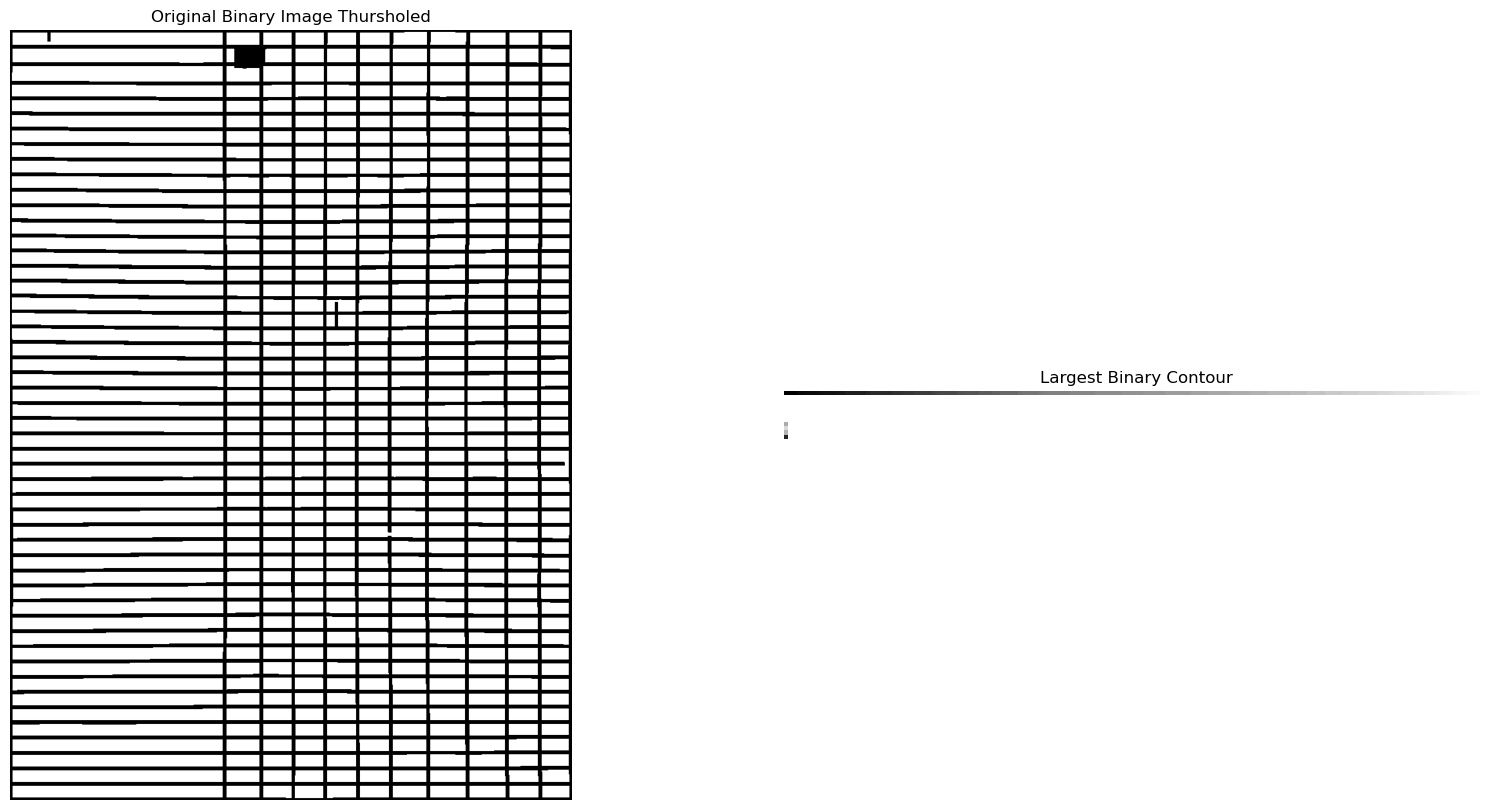

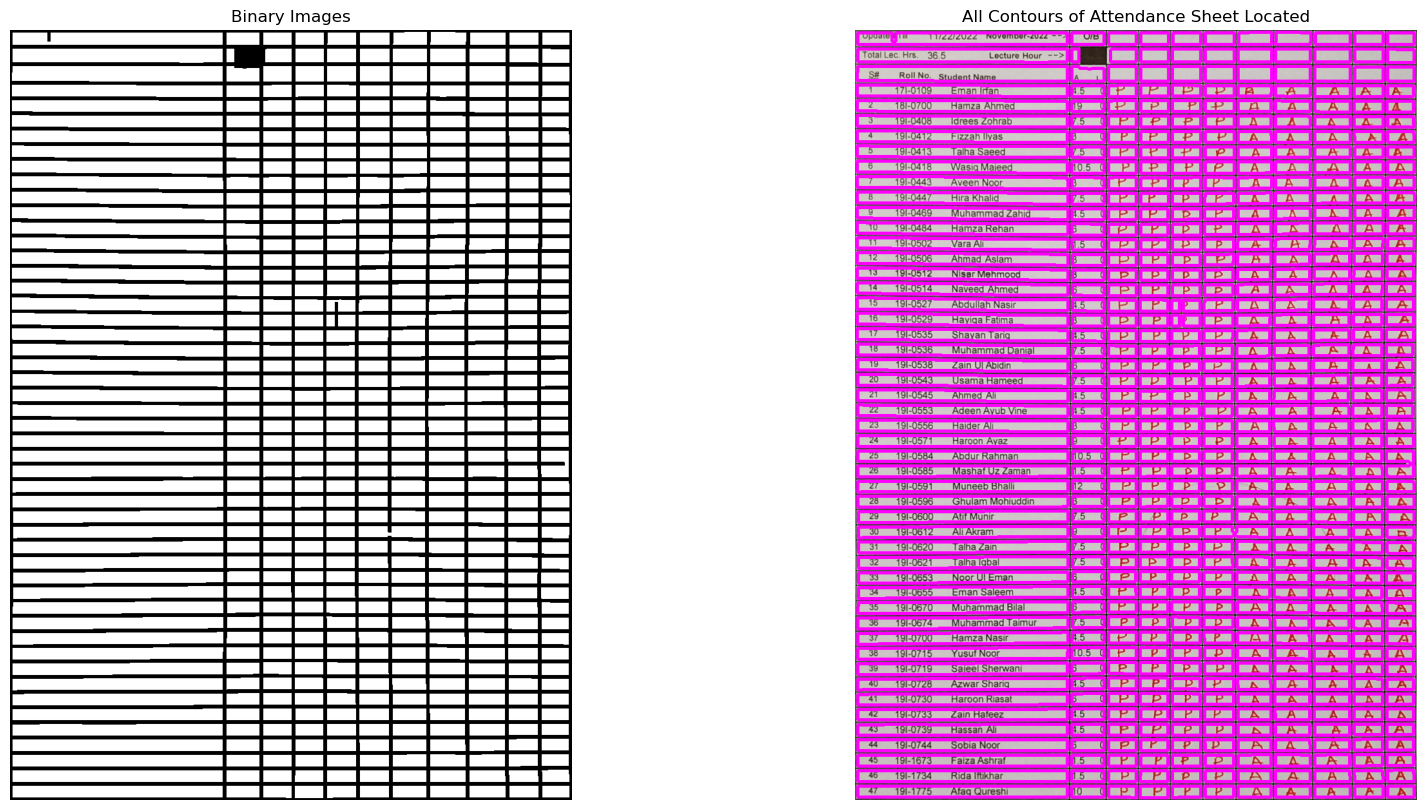

In [13]:
t1 =testing
extract_roi(t1)

In [14]:
finalImgBin = 0
mainLst= []
xLst = []
yLst = []
def extract_roi2(processed_image):
    copy_img =processed_image.copy()

    # converting the image in to grayscale
    gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)

    # thresholding the image
    (thresh, img_bin) = cv2.threshold(gray, 128, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # invert the binary image
    img_bin = 255-img_bin 

    #display image
#     imshow_two_images(processed_image,'Original Image',img_bin,'Inverted Thursholded Image',1)  

    #--------------------------------------- Defining the Kernel -------------------------------------------------------
    # Defining a kernel length
    kernel_length = np.array(copy_img).shape[1]//80

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    #------------------- Process of detecting the vertical and horizontal lines ----------------------------------------
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)


    # displaying the vertical and horizontal lines
#     imshow_two_images(horizontal_lines_img,'Horizontal Lines',verticle_lines_img,'Vertical Lines',1)  

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#     imshow_two_images(processed_image,'Original Image',img_final_bin,'Extraced Grid of the Image',1) 
    # ----------------------------------------------------------------------------------------------------------------------

    # -----------------------Finding the largest possible contour of the thursholded image ---------------------------------
    largest_contour_binary_image =align_image(img_final_bin,1)
#     imshow_two_images(img_final_bin,'Original Binary Image Thursholed',largest_contour_binary_image,'Largest Binary Contour',1) 
#     cv2.imshow('a',img_final_bin)
#     cv2.waitKey()
#     cv2.destroyAllWindows()

    finalImgBin = img_final_bin

    # Finding Contours
    # contours, _ = cv2.findContours(output_canny_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(img_final_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

    # Plotting the contours
    contoursFrame = processed_image.copy()
    contoursFrame = cv2.drawContours(contoursFrame, contours, -1, (255, 0, 255), 4)
    imshow_two_images(img_final_bin,'Binary Images',contoursFrame,'All Contours of Attendance Sheet Located',1)


    # image cutting
    maxIdx=contours[12]
    secondMaxIdx=contours[12]
    idx = 0
    for c in contours:
    # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        maxX,maxY,maxW,maxH=cv2.boundingRect(maxIdx)
        secondMaxX,secondMaxY,secondMaxW,secondMaxH=cv2.boundingRect(secondMaxIdx)
        
        if(w*h > maxW*maxH):
            secondMaxIdx=maxIdx
            maxIdx = c
        if(w*h < maxW*maxH and w*h > secondMaxH*secondMaxW):
            secondMaxIdx = c
        # If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
#         if (w > 50 and h > 20) and w > 3*h:
        idx += 1
        new_img = processed_image[y:y+h, x:x+w]
        cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)
        # imshow_single_image('single cut',new_img)
#         cv2.imshow('singlecut',new_img)
#         cv2.waitKey()
#         cv2.destroyAllWindows()

#     x,y,w,h = cv2.boundingRect(secondMaxIdx)
#     new_img = processed_image[y:y+h, x:x+w]
#     cv2.imshow('a',new_img)
#     cv2.waitKey()
#     cv2.destroyAllWindows()
    startCounting=False
    count = 0
    lst = []
    firstIter=False
    for c in contours:
    # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        if startCounting == True:
            count+=1
        if cv2.boundingRect(c) == cv2.boundingRect(secondMaxIdx):
            startCounting=True
        # If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
#         if (w > 50 and h > 20) and w > 3*h:
        idx += 1
        if count >= 33 and w>5 and h >5:#start appending
            mainLst.append(processed_image[y:y+h,x:x+w])
            xLst.append(x)
            yLst.append(y)
#             if firstIter == False:
#                 lst.append(processed_image[y:y+h,x:x+w])
#                 prevY = y
#                 firstIter = True
#             elif y <= prevY + 10:
#                 lst.append(processed_image[y:y+h,x:x+w])
#                 prevY = y
#             else:
#                 list.reverse(lst)
#                 mainLst.append(lst)
#                 lst= []
#                 lst.append(processed_image[y:y+h,x:x+w])
#                 prevY = y


a


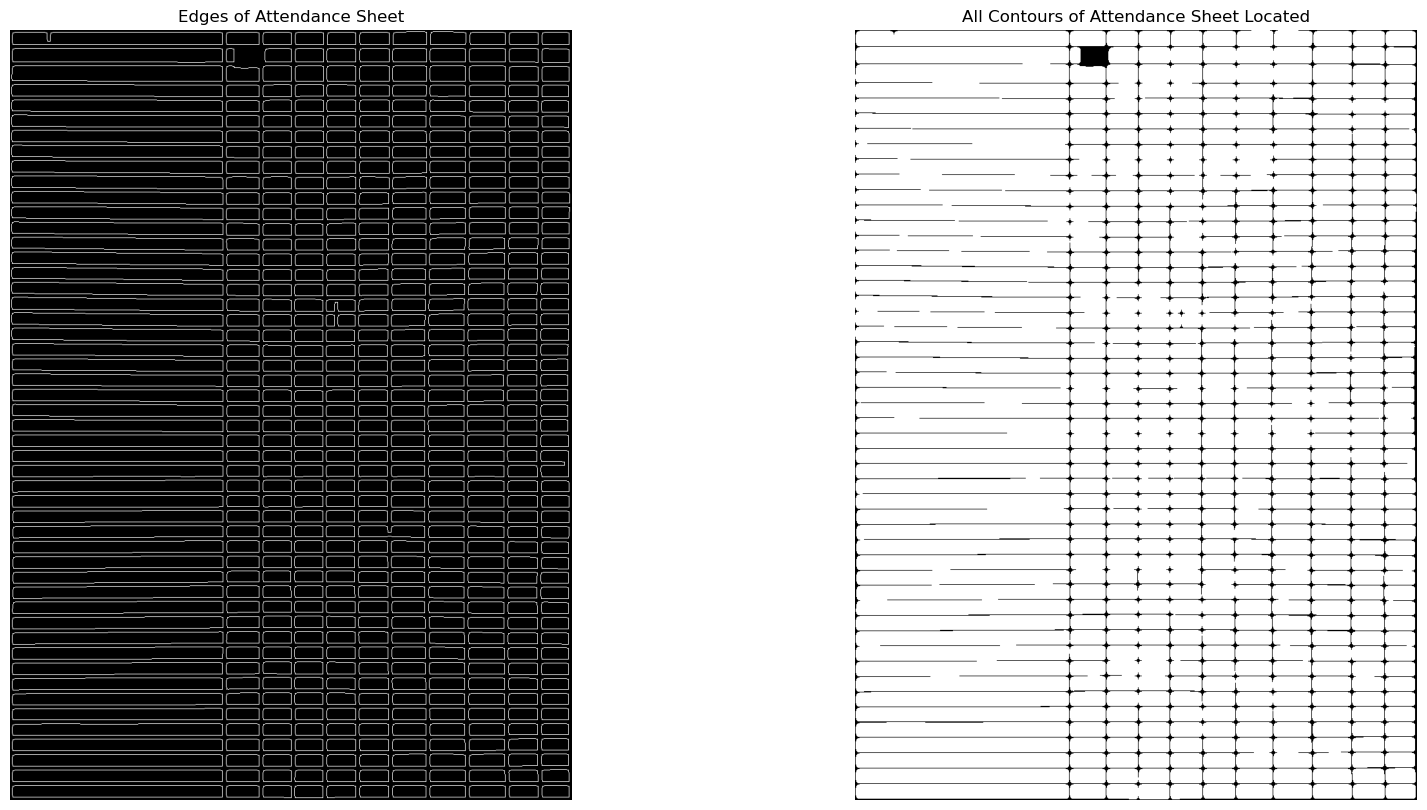

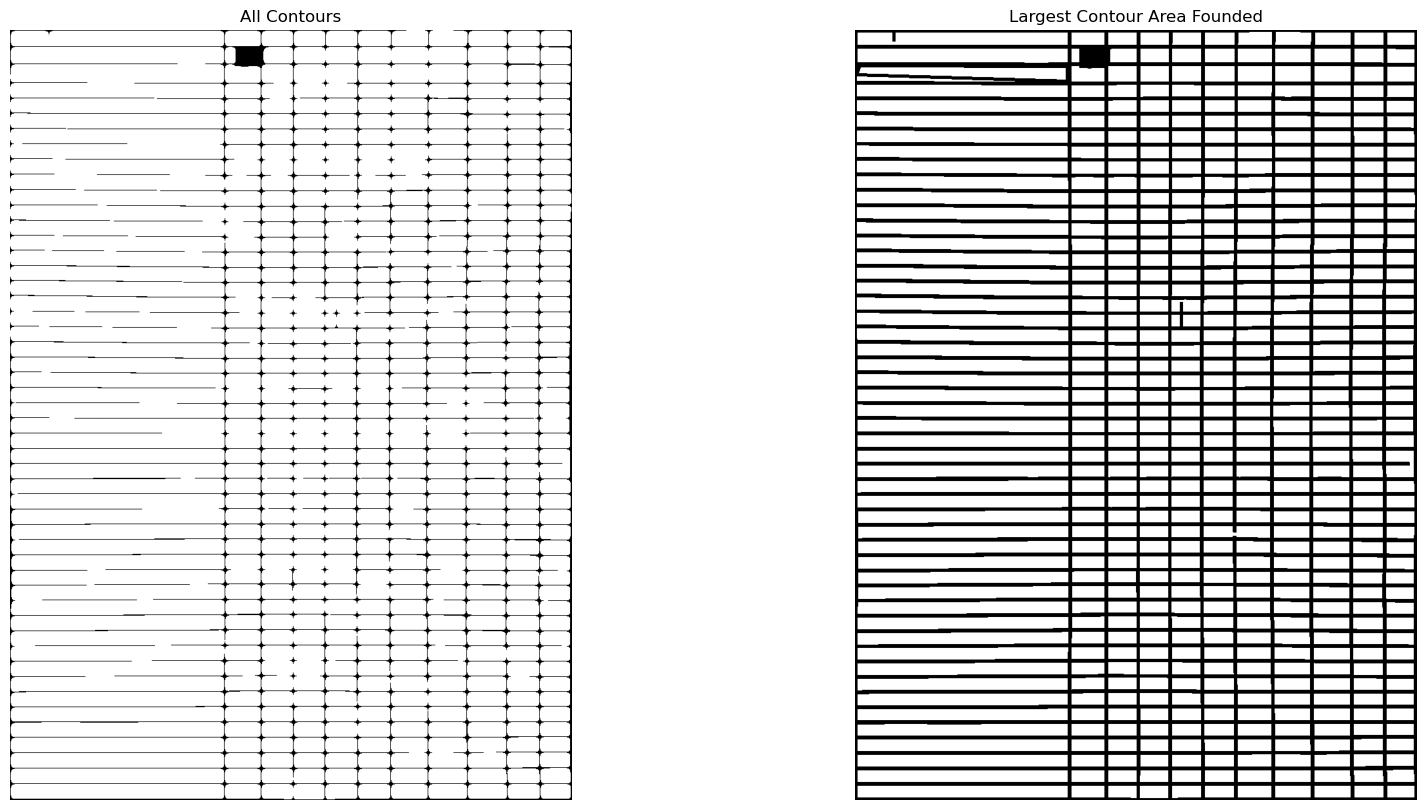

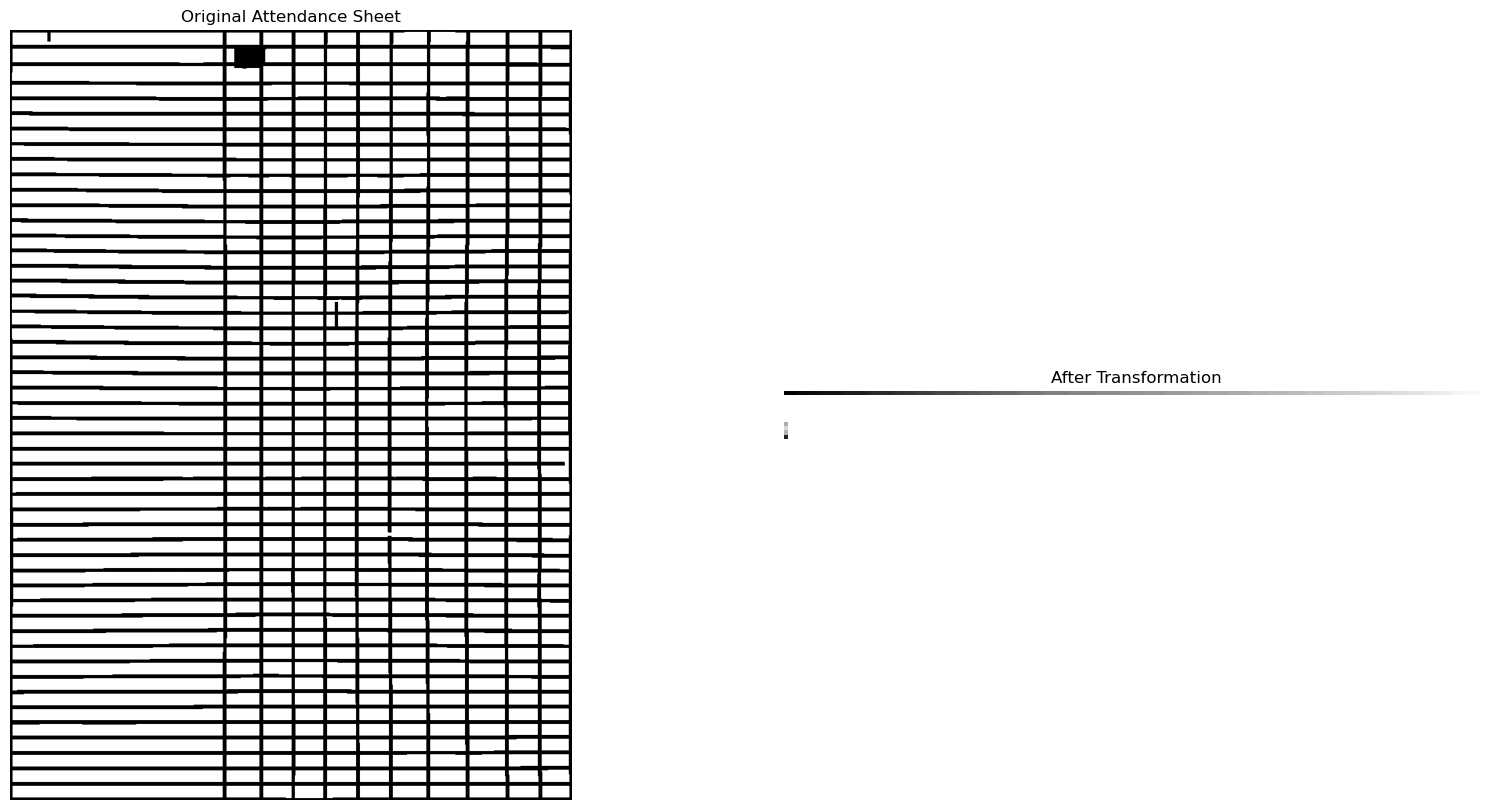

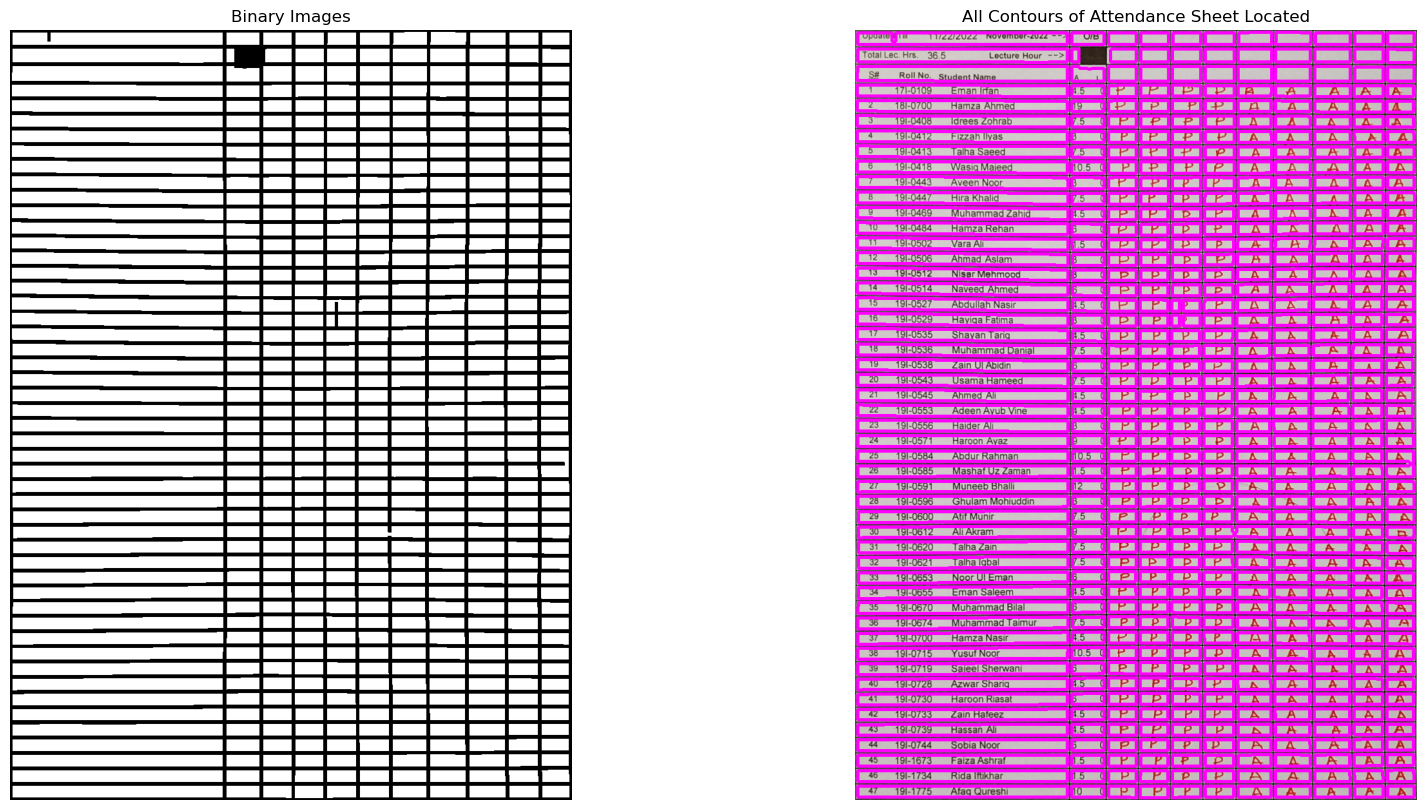

In [15]:
mainLst= []
xLst = []
yLst = []
t1 =testing
extract_roi2(t1)

In [16]:
for i in range(0, len(xLst)):    
    for j in range(i+1, len(xLst)):    
        if(xLst[i] > xLst[j]):    
            temp = xLst[i];    
            xLst[i] = xLst[j];    
            xLst[j] = temp;       
            temp = yLst[i];    
            yLst[i] = yLst[j];    
            yLst[j] = temp;       
            temp = mainLst[i];    
            mainLst[i] = mainLst[j];    
            mainLst[j] = temp;    


In [17]:
sets = {}

In [18]:
len(mainLst)

495

In [19]:
# y = yLst[0]
# sets[y] = []
# sets[f'{y}'] = sets[f'{y}'] + [mainLst[0]]
# sets[y].append(mainLst[0])


#Ahmed P P P
#Aslam A A A
#Ali   P A P
#             -> P,P,P,Ahmed,A,A,A,Aslam,P,A,P,Ali
#0 10 20 30
#1 9  20 30
#0 10 20 29
#After x-sort-> Ahmed,Ali,Aslam,A,P,P,P,A,P,P,P,A
#0  0   1   1
#9  10  9   9
#20 20 19  21
#31 30 28  32
#After sets making
#0, -5,+5 range
#9,  4,14 range
#20  15,25 range
#30  25,35 range


In [20]:
for i in range(0,len(mainLst)):
    setFound = False
    for k in sets.keys():
        if  k >= yLst[i] - 10 and k <= yLst[i] + 10:
            setFound = True
            sets[k].append(mainLst[i])
            break
    if not setFound:
        sets[yLst[i]] = []
        sets[yLst[i]].append(mainLst[i])

In [21]:
print(len(sets.keys()))
# cv2.imshow('a',sets[1028][0])
# cv2.waitKey()
# cv2.destroyAllWindows()

46


In [22]:
sets.keys()
#699 ->#Ali   P A P

dict_keys([132, 156, 179, 203, 227, 251, 275, 298, 322, 345, 369, 392, 415, 439, 463, 487, 511, 534, 558, 581, 605, 629, 653, 676, 699, 723, 887, 911, 934, 958, 982, 1006, 1030, 1053, 1077, 1101, 1125, 1149, 1173, 770, 793, 817, 841, 863, 746, 110])

In [23]:
sets = {k:v for k,v in sorted(sets.items())}

In [24]:
sets.keys()

dict_keys([110, 132, 156, 179, 203, 227, 251, 275, 298, 322, 345, 369, 392, 415, 439, 463, 487, 511, 534, 558, 581, 605, 629, 653, 676, 699, 723, 746, 770, 793, 817, 841, 863, 887, 911, 934, 958, 982, 1006, 1030, 1053, 1077, 1101, 1125, 1149, 1173])

In [25]:
# cv2.imshow('a',sets[99][0])
# cv2.waitKey()
# cv2.destroyAllWindows()

# TRAINING MODEL

In [26]:
absents = []
presents = []
for filename in os.listdir('./ModelTraining/absents'):
    img = cv2.imread(os.path.join('./ModelTraining/absents',filename))
    if img is not None:
        absents.append(img)

for filename in os.listdir('./ModelTraining/presents'):
    img = cv2.imread(os.path.join('./ModelTraining/presents',filename))
    if img is not None:
        presents.append(img)


In [33]:
cv2.imshow('a',presents[0])
cv2.waitKey()
cv2.destroyAllWindows()

In [28]:
hogs = []
labels = []#0 for absent, 1 for present
for img in absents:
    resized_img = cv2.resize(img, (64, 128))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hogs.append(fd)
    labels.append(0)

for img in presents:
    resized_img = cv2.resize(img, (64, 128))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hogs.append(fd)
    labels.append(1)

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\1717542150.py:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\1717542150.py:11: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)


In [29]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 50, max_depth=None, min_samples_split=2, random_state=0)

classifier.fit(hogs,labels)
#P A P A P ->hog feature vectors
#1 0 1 0 1 ->labels
print(classifier.score(hogs,labels))

1.0


In [30]:
classifier.predict(hogs[1].reshape(-1,3780))

array([0])

In [31]:
for key in sets.keys():
    for i in range(2,len(sets[key])):
        resized_img = cv2.resize(sets[key][i], (64, 128))
        fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        if classifier.predict(fd.reshape(-1,3780)) == 0:#absent
            sets[key][i] = 'A'
        else:
            sets[key][i] = 'P'

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
C:\Users\Umer Mukhtar\AppData\Local\Temp\ipykernel_15448\842086357.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2

In [32]:
for key in sets.keys():
#     print(len(sets[key]))
    for i in range(2,len(sets[key])):
        print(sets[key][i],end='')
    print('')


PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAPAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA
PPPPAAAAA


# Performing Thursholding for the Processed Image

# Using EASY OCR

In [14]:
reader = easyocr.Reader(['en'])
result = reader.readtext(processed_image1)
result

NameError: name 'easyocr' is not defined

In [ ]:
all_text = []

# iterate over our extracted text 
for (bbox, text, prob) in result:
    # display the OCR'd text and the associated probability of it being text
    print(f" Probability of Text: {prob*100:.3f}% OCR'd Text: {text}")

    # get the bounding box coordinates
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    # Remove non-ASCII characters from the text so that
    # we can draw the box surrounding the text overlaid onto the original image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    all_text.append(text)
    cv2.rectangle(processed_image, tl, br, (255, 0, 0), 2)
    cv2.putText(processed_image, text, (tl[0], tl[1] - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# show the output image
imshow_single_image("Text With Bounding Boxes", processed_image)

In [ ]:
cv2.imwrite(f'{path_output}/1.jpg',processed_image)

In [ ]:
# # smooting canny edges
#   # Create our shapening kernel, remember it must sum to one 
#   kernel_sharpening = np.array([[-1,-1,-1], 
#                               [-1, 9,-1],
#                               [-1,-1,-1]])

#   #  applying the sharpening kernel to the image
#   sharpened = cv2.filter2D(canny_edges, -1, kernel_sharpening)
#   imshow_two_images(sharpened,'Canny Sharped',canny_edges,'Canny Edges',1)

#   kernel = np.ones((10,10), np.uint8)
#   closing = cv2.morphologyEx(sharpened, cv2.MORPH_CLOSE, kernel)
#   imshow_two_images(sharpened,'Canny Sharped',closing,'Morphological Closing',1)
#   # dilation = cv2.dilate(sharpened, kernel, iterations = 2)
#   # imshow_two_images(sharpened,'Canny Sharped',dilation,'Morphological Dilaltion',1)




#   # Step #3 For the cell wise traversal we use hough line detection
#   rho = 1
#   theta = np.pi/180
#   threshold = 10
#   minLinLength = 400
#   maxLineGap = 6
#   # linesP = cv2.HoughLinesP(canny_edges, 1, np.pi / 180, 100, 3, 25)
#   linesP = cv2.HoughLinesP(sharpened, rho , theta, threshold, None, minLinLength, maxLineGap)

#   if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         if (is_vertical(l)):
#             vertical_lines.append(l)
                
#         elif (is_horizontal(l)):
#             horizontal_lines.append(l)
#   for i, line in enumerate(horizontal_lines):
#       cv2.line(table_copy, (line[0], line[1]), (line[2], line[3]), (0,255,0), 3, cv2.LINE_AA)
                      
#   for i, line in enumerate(vertical_lines):
#       cv2.line(table_copy, (line[0], line[1]), (line[2], line[3]), (0,0,255), 3, cv2.LINE_AA)


#   imshow_two_images(table_image,'Original Image',table_copy,'After Hough Lines Detection',0)